In [1]:
from keras.layers.convolutional import Conv2D, AtrousConvolution2D
from keras.layers import Activation, Dense, Input, Conv2DTranspose, Dense, Flatten
from keras.layers import ReLU, Dropout, Concatenate, BatchNormalization, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.convolutional import UpSampling2D
import keras.backend as K
import tensorflow as tf
from keras_contrib.layers import InstanceNormalization
import os
import numpy as np
import PIL
import cv2
import IPython.display
from IPython.display import clear_output
from datetime import datetime
from dataloader import Data, TestData
import sys

Using TensorFlow backend.
/Users/yash/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yash/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yash/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yash/opt/anaconda3/lib/python3.7/site-pa

In [2]:
EPSILON = 1e-9

In [3]:
print(sys.version)

3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [4]:
CHECKPOINT = "checkpoint/"

In [5]:
def dcrm_loss(y_true, y_pred):
    return -tf.reduce_mean(tf.log(tf.maximum(y_true, EPSILON)) + tf.log(tf.maximum(1. - y_pred, EPSILON)))

In [6]:
DCRM_OPTIMIZER = Adam(0.0001, 0.5)
INPUT_SHAPE = (256, 256, 3)
MASK_PERCENTAGE = .25
GEN_OPTIMIZER = Adam(0.001, 0.5)
g_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])


In [7]:
def load_model():
    # Checking if all the model exists
    model_names = ['DCRM', 'GEN']
    files = os.listdir(CHECKPOINT)
    for model_name in model_names:
        if model_name+".json" not in files or\
           model_name+".hdf5" not in files:
            print("Models not Found")
            return
    global DCRM, GEN, COMBINED, IMAGE, GENERATED_IMAGE, CONF_GENERATED_IMAGE
    
    # load DCRM Model
    model_path = CHECKPOINT + "%s.json" % 'DCRM'
    weight_path = CHECKPOINT + "%s.hdf5" % 'DCRM'
    with open(model_path, 'r') as f:
        DCRM = model_from_json(f.read())
    DCRM.load_weights(weight_path)
    DCRM.compile(loss=dcrm_loss, optimizer=DCRM_OPTIMIZER)
    
    #load GEN Model
    model_path = CHECKPOINT + "%s.json" % 'GEN'
    weight_path = CHECKPOINT + "%s.hdf5" % 'GEN'
    with open(model_path, 'r') as f:
         GEN = model_from_json(f.read(), custom_objects={'InstanceNormalization': InstanceNormalization()})
    GEN.load_weights(weight_path)
    
    # Combined Model
    DCRM.trainable = False
    IMAGE = Input(shape=g_input_shape)
    GENERATED_IMAGE = GEN(IMAGE)
    CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

    COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
    COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)
    
    print("loaded model")
    

In [8]:

def get_demask_images(original_images, generated_images):
    demask_images = []
    for o_image, g_image in zip(original_images, generated_images):
        width = g_image.shape[1] // 2
        x_image = g_image[:, :width]
        y_image = g_image[:, width:]
        o_image = np.concatenate((x_image,o_image, y_image), axis=1)
        demask_images.append(o_image)
    return np.asarray(demask_images)

In [9]:
load_model()

loaded model


Downloaded image
(1, 256, 128, 3)
original image


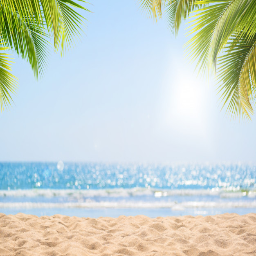

predicted image


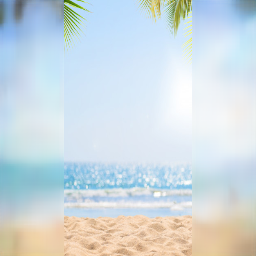

In [12]:
#url = "https://img.freepik.com/free-photo/empty-sea-beach-background_74190-313.jpg?size=626&ext=jpg"
url = "https://image.freepik.com/free-photo/abstract-seascape-with-palm-tree-tropical-beach-background_1484-1999.jpg"
file_name = os.path.basename(url)
import urllib.request
_ = urllib.request.urlretrieve(url, file_name)
print("Downloaded image")

image = cv2.imread(file_name)
image = cv2.resize(image, (256,256))
cropped_image = image[:, 65:193]
input_image = cropped_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)
print(input_image.shape)
predicted_image = GEN.predict(input_image)
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

print('original image')
IPython.display.display(PIL.Image.fromarray(image))
print('predicted image')
IPython.display.display(PIL.Image.fromarray(predicted_image))

os.remove(file_name)